In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import butter, filtfilt

Lock-in Digital para extraer $\phi(t)$ y $A(t)$.

In [33]:
def lock_in(signal, omega, fs, cutoff_freq=1):
    # Crear señales de referencia: cos(omega * t) y sin(omega * t)
    ts = ts = np.arange(len(signal)) / fs  # Generar tiempo con la frecuencia de muestreo
    ref_cos = np.cos(omega * ts)
    ref_sin = np.sin(omega * ts)

    # Realizar lock-in digital (multiplicar por la señal de referencia)
    in_phase = signal * ref_sin
    quadrature = signal * ref_cos

    # Filtrar la señal para obtener las componentes en fase y cuadratura
    b, a = butter_lowpass(cutoff_freq, fs)
    in_phase_filtered = filtfilt(b, a, in_phase)
    quadrature_filtered = filtfilt(b, a, quadrature)

    # Amplitud A(t) y fase phi(t)
    A_t = np.sqrt(in_phase_filtered**2 + quadrature_filtered**2)
    phi_t_extracted = np.arctan2(quadrature_filtered, in_phase_filtered)

    return A_t, phi_t_extracted

# Función de filtro pasa-bajas
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

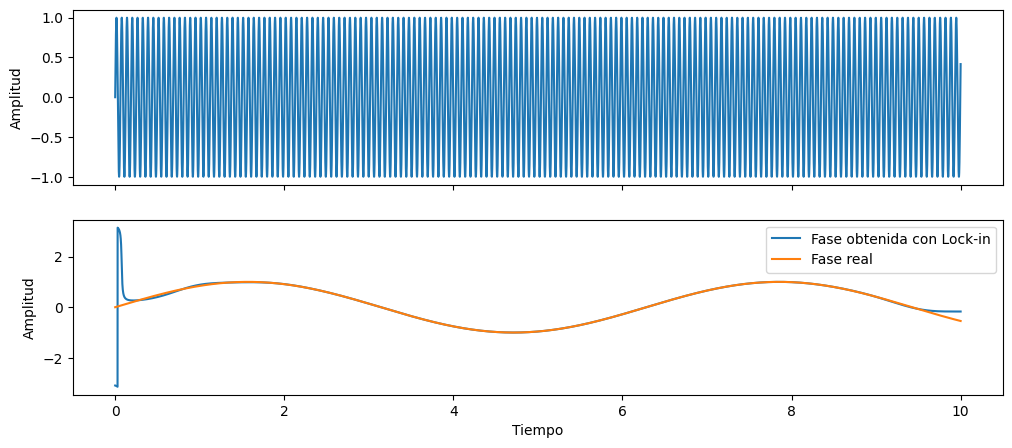

In [34]:
omega_ref = 100
omega_sig = 1
A = 1

def phi(t):
    return A * np.sin(omega_sig * t)

ts = np.linspace(0, 10, 10000)
signal = np.sin(omega_ref * ts + phi(ts))

extracted_A, extracted_phi = lock_in(signal, omega_ref, 1/(ts[1]-ts[0]))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
axs[0].plot(ts, signal, label="Señal")
axs[1].plot(ts, extracted_phi, label="Fase obtenida con Lock-in")
axs[1].plot(ts, phi(ts), label="Fase real")

axs[0].set_ylabel("Amplitud")
axs[1].set_xlabel("Tiempo")
axs[1].set_ylabel("Amplitud")

plt.legend()
plt.show()

Circuito RLC con capacitancia de la forma $C = C_0 + \Delta C(t)$ donde asumimos que $\Delta C(t) = C'*l(t)$ con $l(t)$ la altura que nos interesa obtener. Vale resaltar que $C_0 = C_{\text{extra}} + C_{eq}$. La ecuación del circuito es:

$V = \cos(\omega t)\frac{d^2I}{dt^2} + \frac{R}{L} \frac{dI}{dt} + \frac{1}{C(t)L} I$

Siempre que $\Delta C / C_0 \ll 1$ se puede mostrar que: 

$\tan(\phi) = -\frac{1}{R} \left[\omega L - \frac{1}{\omega C_0}\right] - \frac{1}{R} \frac{\Delta C}{\omega C_0^2} + O\left[\left(\frac{\Delta C}{C_0}\right)^2\right]$

Que eligiendo convenientemente $\omega^2=1/(L*C_0)$ resulta en que:

$\phi = -Q_F * \frac{\Delta C}{C_0} = - Q_F \frac{C'}{C_0} l(t) \qquad Q_F = \frac{1}{R}\sqrt{(\frac{L}{C_0})}$

In [47]:
R = 1.00 # Aumentar R aumenta el retraso y disminuirlo aumenta el rudo.
L = 0.01 # Disminuir L disminuye el retraso en la señal.
C0 = 0.0005 # Aumentar C0 hace que w baje y no llega el tiempo de respuesta del sistema. 
V = 1
C = 1e-5

omega = 1 / np.sqrt(C0 * L)  # Frecuencia omega = 1/sqrt(C0 * L)
Q = (1 / R) * np.sqrt(L / C0)

In [48]:
# Funciones de capacitancia variable y ecuaciones diferenciales
def l(t):
    x0 = 50
    # omega2 = 0.1
    return np.exp(-0.01*(t-x0)**2) # np.sin(omega2*t)

def C_(t):
    return C0 + C * l(t)

def dXdt(X, t):
    i, didt = X
    didt2 = V * np.cos(omega * t) - R / L * didt - 1 / (C_(t) * L) * i
    return [didt, didt2]

# Solución de la EDO
ts = np.linspace(0, 100, 100000)
y0 = [0, 0]
sol = odeint(dXdt, y0, ts)
current = sol[:, 0]  # Corriente

# plt.plot(ts, current)
# plt.xlim(0, 0.1)
# plt.show()


In [49]:
# Parámetros de la FFT y frecuencia de muestreo
fs = 1 / (ts[1] - ts[0])  # Frecuencia de muestreo

# Aplicar el lock-in para extraer amplitud y fase
A_t, phi_t_extracted = lock_in(current, omega, fs)

unwrapped = np.unwrap(phi_t_extracted)
reconstructed_heights = -C0 * unwrapped / Q / C

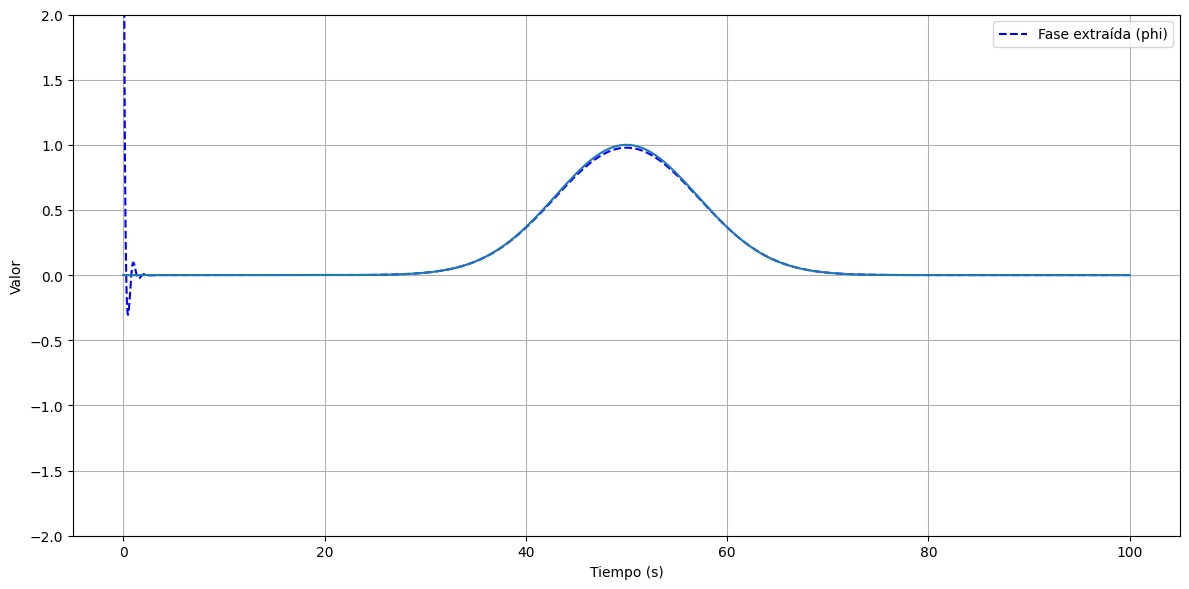

In [50]:
# Graficar los resultados
plt.figure(figsize=(12, 6))

# Gráfica de la expresión normalizada
plt.plot(ts, reconstructed_heights - reconstructed_heights[-100], label="Fase extraída (phi)", linestyle='--', color='blue')
plt.plot(ts, l(ts) - l(ts)[-100]) # s 

plt.xlabel("Tiempo (s)")
plt.ylabel("Valor")
plt.legend()
plt.grid()

plt.ylim(-2, 2)
plt.tight_layout()
plt.show()


Ahora vamos a compactar el código para estudiar más fácil qué pasa al variar parámetros y estudiar los límites en la sensibilidad y el tiempo de respuesta.

In [51]:

def measured_l(ts, l, C0, C, R, L, V=5, cutoff_freq=1):
    omega = 1 / np.sqrt(C0 * L)
    Q = (1 / R) * np.sqrt(L / C0)

    def C_(t):
        return C0 + C * l(t)

    def dXdt(X, t):
        i, didt = X
        didt2 = V * np.cos(omega * t) - R / L * didt - 1 / (C_(t) * L) * i
        return [didt, didt2]

    y0 = [0, 0]
    sol = odeint(dXdt, y0, ts)
    current = sol[:, 0]  

    _, phi_t_extracted = lock_in(current, omega, fs = 1 / (ts[1] - ts[0]), cutoff_freq=cutoff_freq)

    unwrapped = np.unwrap(phi_t_extracted)
    reconstructed_heights = -C0 * unwrapped / (Q * C)

    return reconstructed_heights

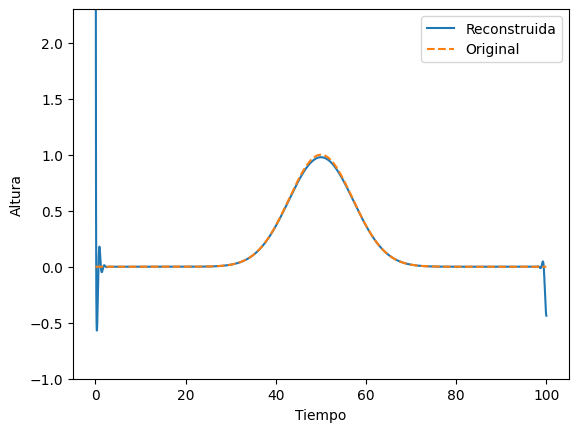

In [52]:
ts = np.linspace(0, 100, 10000)
ls = measured_l(ts, l, C0, C, R, L)

plt.ylim(-1, 2.3)
plt.plot(ts, ls, label="Reconstruida")
plt.plot(ts, l(ts), "--", label="Original")
plt.xlabel("Tiempo")
plt.ylabel("Altura")
plt.legend()
plt.show()

# Histeresis

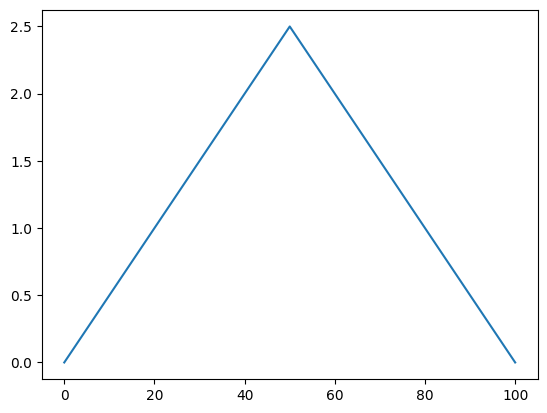

In [53]:
def l_(t):
    if t<50:
        return 0.05*t
    elif t>50:
        return -0.05*(t-100)
    
l = np.vectorize(l_)
plt.plot(ts, l(ts))
plt.show()    

In [54]:
ts = np.linspace(0, 100, 10000) # 0 
ls = measured_l(ts, l, C0, C, R, L)

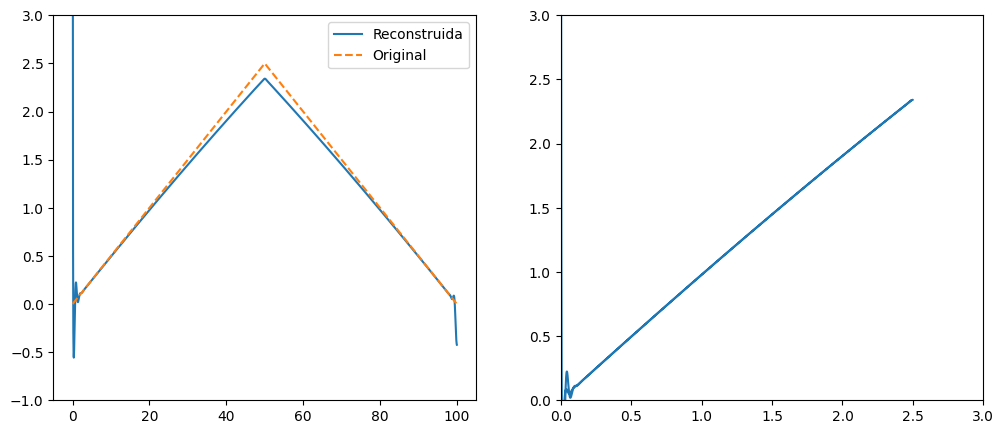

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.ylim(-1, 3)
plt.plot(ts, ls, label="Reconstruida")
plt.plot(ts, l(ts), "--", label="Original")
plt.legend()


plt.subplot(122)
plt.plot(l(ts), ls)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.show()

Variar parámetros para mejorar sensibilidad.

In [56]:
def l(t):
    return 0.15*t

ls =  measured_l(ts, l, C0, C, R, L)

(-1.0, 16.5)

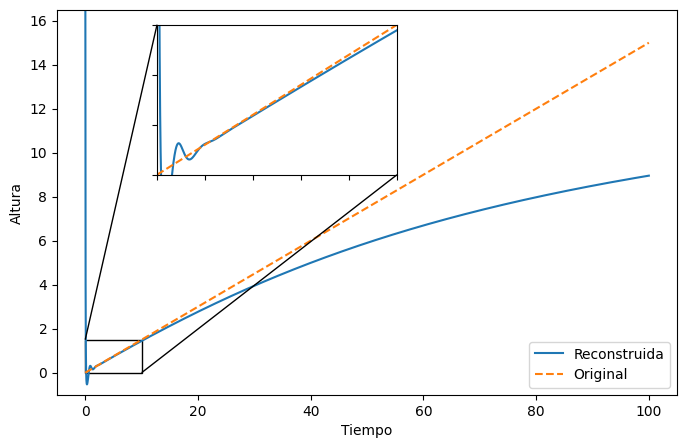

In [57]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ts, ls, label="Reconstruida")
ax.plot(ts, l(ts), "--", label="Original")
ax.legend()
ax.set_xlabel("Tiempo")
ax.set_ylabel("Altura")


# Crear un inset manualmente con [left, bottom, width, height] en coordenadas de figura (0-1)
ax_inset = fig.add_axes([0.25, 0.55, 0.3, 0.3])  # (x, y, ancho, alto)

# Dibujar la región de interés en el inset
ax_inset.plot(ts, ls, label="Reconstruida")
ax_inset.plot(ts, l(ts), "--", label="Original")

# Configurar límites del zoom
ax_inset.set_xlim(0, 10)  # Ajustar al rango deseado
ax_inset.set_ylim(0, 10*0.150)  # Ajustar según los valores

# Remover etiquetas del inset para claridad
ax_inset.set_xticklabels([])
ax_inset.set_yticklabels([])

# Dibujar líneas conectando el inset con la gráfica principal
mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="black")

ax.set_ylim(min(l(ts))-1, 1.1*max(l(ts)))

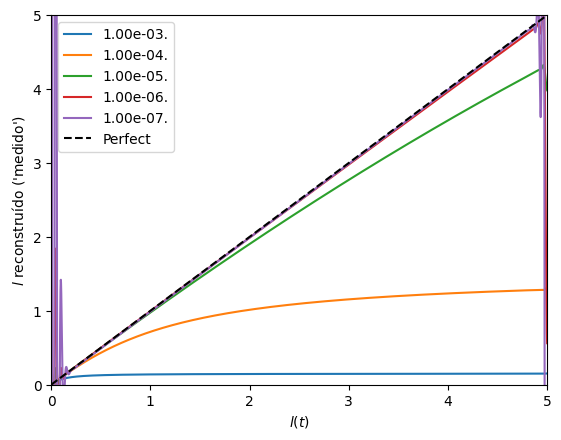

In [58]:
def l(t):
    return 0.05*t

Cs = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

for C in Cs:
    ls =  measured_l(ts, l, C0, C, R, L)
    plt.plot(l(ts), ls, label=f"{C:.2e}.")

plt.plot(l(ts), l(ts), "--", label="Perfect", color="black")
plt.xlim(min(l(ts)), max(l(ts)))
plt.ylim(min(l(ts)), max(l(ts)))
plt.legend()

plt.xlabel("$l(t)$")
plt.ylabel("$l$ reconstruído ('medido')")
plt.show()    

Cuanto más pequeño es $C$ más rango de $l$'s puede medir ya que se mantiene la aproximación de fases pequeñas por más tiempo. Vale aclarar que $C = \frac{2\pi\varepsilon}{\ln{r_2/r_1}}$. Si $r_2=r_1+e$ entonces con $e/r_1 \ll 1$ vale que $C = 2\pi\varepsilon\;\frac{r_1}{e}$. NOTA: Esto no me convence porque en el texto dicen que al aumentar $r_1$ o disminuir $e$ se vuelve más sensible.

<!-- % C =  -->

Para medir cambios de $l$ más rápidos hay que aumentar la frecuencia moduladora para lo cual hay que modificar esencialmente $C_0$ y L. 

<!-- h -->

# Valores Reales

Para comparar con los datos del paper ellos usan:

$C_0 = 150e-12$ F de base más una capacitancia extra de $10e-12$ F del cable sumergido. (Dicen en un lugar que es 10 pF y en otro 100 pF. Para que de la frecuencia que usan debería ser 10 pF.)

$L = 22e-3$ H.

$R = 1e1 - 1e3$ $\Omega$. 

Lo único que no nos dicen es el valor de $C'$, pero por la calibración sabemos que $-0.430e-3$ m/° $= -\frac{1}{Q_F}\frac{C_0}{C'}. $

Frecuencia de sampleo: 1.000e+07 Hz.
Frecuencia $\omega$ = 7.071e+05 Hz.
Frecuencia de señal: 5.000e+02 Hz.


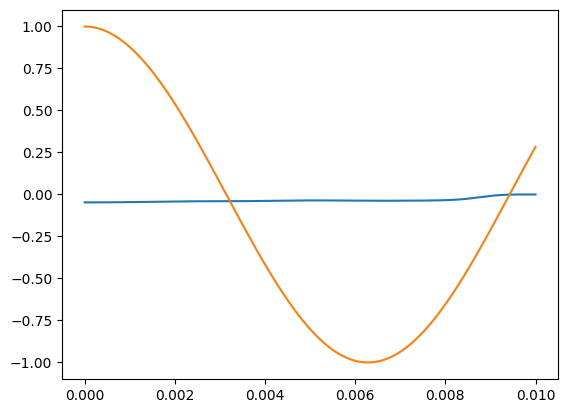

In [59]:
R_f = 1e3 
C0_f = 1e-10 
C_f = 1e-12 
L_f = 0.02 
omega2 = 0.5e3

def l(t):
    return np.cos(omega2*t)

ts = np.linspace(0, 5/omega2, 100000)
ls = measured_l(ts, l, C0_f, C_f, R_f, L_f)

plt.plot(ts, ls - ls[-1])
plt.plot(ts, l(ts))
# plt.ylim(-1.5, 1.5) # 


print(f"Frecuencia de sampleo: {1/(ts[1]-ts[0]):.3e} Hz.")
print(f"Frecuencia $\omega$ = {1/np.sqrt(L_f*C0_f):.3e} Hz.")
print(f"Frecuencia de señal: {omega2:.3e} Hz.")

# Es el LOCK IN

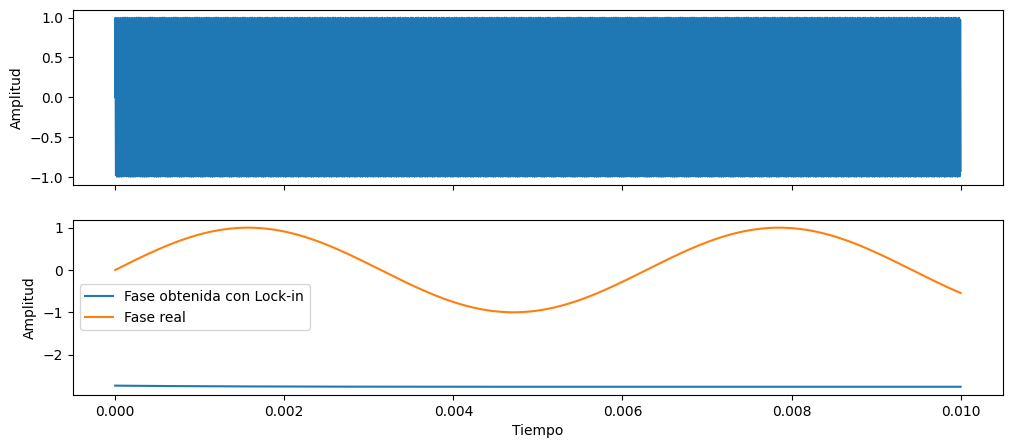

In [60]:
omega_ref = 5e5
omega_sig = 1e3
A = 1

def phi(t):
    return A * np.sin(omega_sig * t)

ts = np.linspace(0, 0.01, 10000)
signal = np.sin(omega_ref * ts + phi(ts))

extracted_A, extracted_phi = lock_in(signal, omega_ref, 1/(ts[1]-ts[0]))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
axs[0].plot(ts, signal, label="Señal")
axs[1].plot(ts, extracted_phi, label="Fase obtenida con Lock-in")
axs[1].plot(ts, phi(ts), label="Fase real")

axs[0].set_ylabel("Amplitud")
axs[1].set_xlabel("Tiempo")
axs[1].set_ylabel("Amplitud")

plt.legend()
plt.show()

# Intento de solución.

In [61]:
def lock_in(signal, omega, fs, cutoff_freq=100000):
    # Crear señales de referencia: cos(omega * t) y sin(omega * t)
    ts = ts = np.arange(len(signal)) / fs  # Generar tiempo con la frecuencia de muestreo
    ref_cos = np.cos(omega * ts)
    ref_sin = np.sin(omega * ts)

    # Realizar lock-in digital (multiplicar por la señal de referencia)
    in_phase = signal * ref_sin
    quadrature = signal * ref_cos

    # Filtrar la señal para obtener las componentes en fase y cuadratura
    b, a = butter_lowpass(cutoff_freq, fs)
    in_phase_filtered = filtfilt(b, a, in_phase)
    quadrature_filtered = filtfilt(b, a, quadrature)

    # Amplitud A(t) y fase phi(t)
    A_t = np.sqrt(in_phase_filtered**2 + quadrature_filtered**2)
    phi_t_extracted = np.arctan2(quadrature_filtered, in_phase_filtered)

    return A_t, phi_t_extracted

# Función de filtro pasa-bajas
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

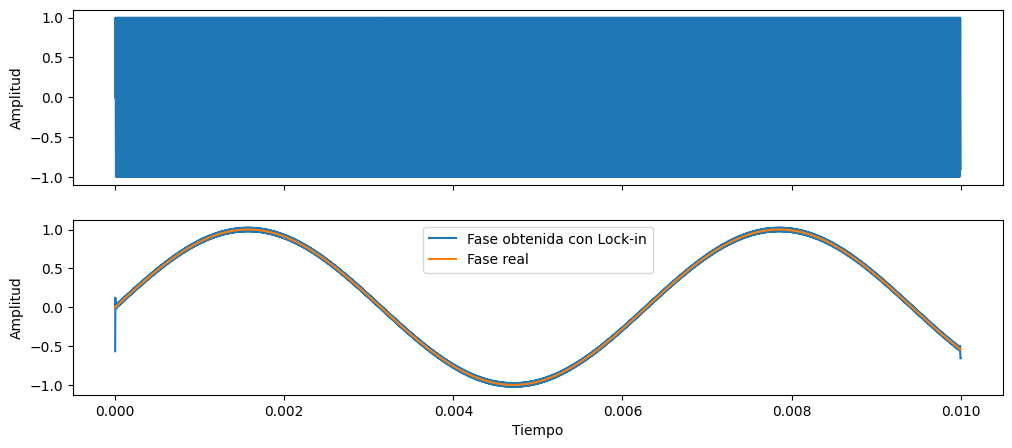

In [62]:
omega_sam = 1e7
omega_ref = 5e5
omega_sig = 1e3
A = 1

def phi(t):
    return A * np.sin(omega_sig * t)

ts = np.arange(0, 100000) / omega_sam
signal = np.sin(omega_ref * ts + phi(ts))

extracted_A, extracted_phi = lock_in(signal, omega_ref, 1/(ts[1]-ts[0]))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
axs[0].plot(ts, signal, label="Señal")
axs[1].plot(ts, extracted_phi, label="Fase obtenida con Lock-in")
axs[1].plot(ts, phi(ts), label="Fase real")

axs[0].set_ylabel("Amplitud")
axs[1].set_xlabel("Tiempo")
axs[1].set_ylabel("Amplitud")

plt.legend()
plt.show()

El tiempo de integración debe estar entre el característico de la señal y el de modulación, osea:

$\tau_s > \tau > \tau_r$

O en frecuencia:

$\omega_s < \omega < \omega_r$

Con el que no tiene subíndice el del filtro. Más tiempo de integración es menos ruido pero menos detalle y menos tiempo es más ruido pero más detalle. 


# PRUEBAS PRELIMINARES


In [ ]:
alpha = -0.43e-3
R_f = 1e3 
C0_f = 160e-12 
L_f = 22e-3 

QF_f = (1 / R_f) * np.sqrt(L_f / C0_f)

C_f = - C0_f / (QF_f * alpha)
print(f"Capacitancia por unidad de longitud: {C_f/1e3:.3e} F/mm.")

Capacitancia por unidad de longitud: 3.173e-11 F/mm.


Esta es efectivamente dos órdenes de magnitud ma´s chica que la que está puesta en paralelo. Podemos medir $l$ hasta que se acerque $C'l$ a algo de orden 100. 
<!-- (Ojo que acá $l$ está en metros así que hay bastante margen). -->

In [92]:
print(f"Frecuencia de resonancia: $\omega$ = {1/np.sqrt(L_f*C0_f):.3e} Hz")

Frecuencia de resonancia: $\omega$ = 5.330e+05 Hz


La subida debería ser muy lenta. Si el circuito y la portadora son del orden de 1e5 Hz entonces deberíamos hacer cosas en el rango de 1e3 Hz que son 1e-3 s.

In [ ]:
omega_sam = 1e7
omega_cutoff = 1e4
omega2 = 1e3

def l(t):
    return 1e-3 * np.cos(omega2 * t) # 0.01*t 

ts = np.arange(0, 1000000) * 1 / omega_sam
ls =  measured_l(ts, l, C0_f, C_f, R_f, L_f, cutoff_freq=omega_cutoff)

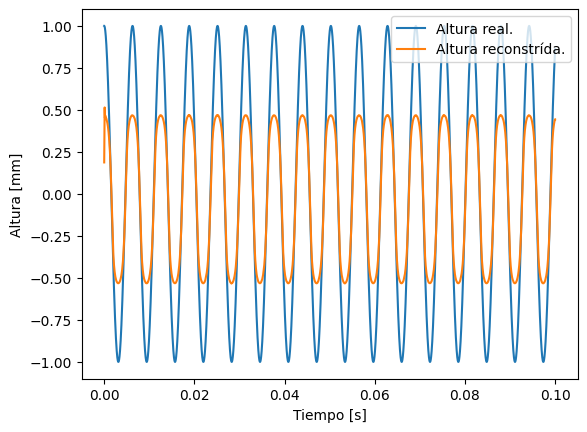

In [94]:
plt.plot(ts, l(ts)*1e3, label="Altura real.")
plt.plot(ts, ls*1e3, label="Altura reconstrída.")
plt.xlabel("Tiempo [s]")
plt.ylabel("Altura [mm]")
plt.legend(loc="upper right")

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

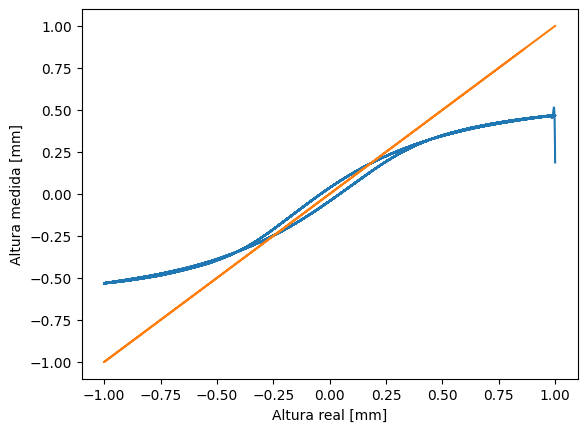

In [95]:
plt.plot(l(ts) * 1e3, ls*1e3, label="Parámetros propuestos")
plt.plot(l(ts) * 1e3, l(ts) * 1e3, label = "Sensor perfecto")
plt.xlabel("Altura real [mm]")
plt.ylabel("Altura medida [mm]")
plt.xlim(1.1 * min(l(ts)) * 1e3, 1.1 * max(l(ts)) * 1e3)
plt.ylim(1.1 * min(l(ts)) * 1e3, 1.1 * max(l(ts)) * 1e3)
plt.legend

Parece tener efectivamente algo de histéresis el sistema. Se reduce cuanto más lento es el movimiento. Buena forma de darse cuenta si está yendo demasiado rápido. Por último remarcar que para que funcione en más rangos de alturas conviene menor $C'$. Parece que aumentar $R$ también parece mejorar el rango a costa de ruido. Imagino que disminuir $Q_F$ en general permite mejorar la validez, ya sea disminuyendo $C'$, aumentando $C_0$ o $R$ o disminuyendo $L$. 

Por ejemplo, para $C'$ ~ 3e-8 que es la que usan con usar $C_0$ ~ 160e-10 que es dos órdenes de magnitud más grande ya te da para medir hasta seguro más de 10 mm para cada lado.
 

 
<!--    q    -->

In [96]:
"""
from scipy.integrate import solve_ivp

def measured_l(t_span, l, C0, C, R, L, V=5):
    omega = 1 / np.sqrt(C0 * L)
    Q = (1 / R) * np.sqrt(L / C0)

    def C_(t):
        return C0 + C * l(t)

    def dXdt(t, X):
        i, didt = X
        didt2 = V * np.cos(omega * t) - R / L * didt - 1 / (C_(t) * L) * i
        return [didt, didt2]

    y0 = [0, 0]
    sol = solve_ivp(dXdt, t_span, y0, dense_output = True)
    ts = np.linspace(t_span[0], t_span[-1], 100000)
    current = sol.sol(ts)[0]  
    
    _, phi_t_extracted = lock_in(current, omega, fs = 1 / (ts[1] - ts[0]))

    unwrapped = np.unwrap(phi_t_extracted)
    reconstructed_heights = -C0 * unwrapped / (Q * C)

    return ts, reconstructed_heights, current
    
"""

'\nfrom scipy.integrate import solve_ivp\n\ndef measured_l(t_span, l, C0, C, R, L, V=5):\n    omega = 1 / np.sqrt(C0 * L)\n    Q = (1 / R) * np.sqrt(L / C0)\n\n    def C_(t):\n        return C0 + C * l(t)\n\n    def dXdt(t, X):\n        i, didt = X\n        didt2 = V * np.cos(omega * t) - R / L * didt - 1 / (C_(t) * L) * i\n        return [didt, didt2]\n\n    y0 = [0, 0]\n    sol = solve_ivp(dXdt, t_span, y0, dense_output = True)\n    ts = np.linspace(t_span[0], t_span[-1], 100000)\n    current = sol.sol(ts)[0]  \n    \n    _, phi_t_extracted = lock_in(current, omega, fs = 1 / (ts[1] - ts[0]))\n\n    unwrapped = np.unwrap(phi_t_extracted)\n    reconstructed_heights = -C0 * unwrapped / (Q * C)\n\n    return ts, reconstructed_heights, current\n    \n'